In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import math
import requests
from bs4 import BeautifulSoup
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import metrics
pd.set_option("display.max_columns",100)

In [2]:
## Proxy settings when using cntlm
http_proxy  = "http://localhost:3128"
https_proxy = "https://localhost:3128"

proxyDict = { 
              "http"  : http_proxy, 
              "https" : https_proxy, 
            }
proxyDict = None

In [40]:
mapping = {
    'Richmond': 'richmond',
    'West Coast': 'westcoast',
    'Sydney': 'swans',
    'Adelaide': 'adelaide',
    'Geelong': 'geelong',
    'Greater Western Sydney': 'gws',
    'Melbourne': 'melbourne',
    'Port Adelaide': 'padelaide',
    'Collingwood': 'collingwood',
    'Hawthorn': 'hawthorn',
    'Essendon': 'essendon',
    'Western Bulldogs': 'bullldogs',
    'St Kilda': 'stkilda',
    'North Melbourne': 'kangaroos',
    'Kangaroos' : 'kangaroos',
    'Fremantle': 'fremantle',
    'Brisbane Lions': 'brisbanel',
    'Gold Coast': 'goldcoast',
    'Carlton': 'carlton'
}
teams = list(mapping.keys())

In [27]:
from data_prep.team_history import History
team_df = History(mapping, proxyDict).generate_team_history()

Richmond 1
Richmond 2
Richmond 3
Richmond 4
Richmond 5
Richmond 6
Richmond 7
Richmond 8
Richmond 9
Richmond 10
Richmond 11
Richmond 12
Richmond 13
Richmond 14
Richmond 15
West Coast 1
West Coast 2
West Coast 3
West Coast 4
West Coast 5
West Coast 6
West Coast 7
West Coast 8
West Coast 9
West Coast 10
West Coast 11
West Coast 12
West Coast 13
West Coast 14
West Coast 15
Sydney 1
Sydney 2
Sydney 3
Sydney 4
Sydney 5
Sydney 6
Sydney 7
Sydney 8
Sydney 9
Sydney 10
Sydney 11
Sydney 12
Sydney 13
Sydney 14
Sydney 15
Adelaide 1
Adelaide 2
Adelaide 3
Adelaide 4
Adelaide 5
Adelaide 6
Adelaide 7
Adelaide 8
Adelaide 9
Adelaide 10
Adelaide 11
Adelaide 12
Adelaide 13
Adelaide 14
Adelaide 15
Geelong 1
Geelong 2
Geelong 3
Geelong 4
Geelong 5
Geelong 6
Geelong 7
Geelong 8
Geelong 9
Geelong 10
Geelong 11
Geelong 12
Geelong 13
Geelong 14
Geelong 15
Greater Western Sydney 1
Greater Western Sydney 2
Greater Western Sydney 3
Greater Western Sydney 4
Greater Western Sydney 5
Greater Western Sydney 6
Greater We

In [10]:
from data_prep.team_history import History
History(mapping, proxyDict).generate_game_data('training-all/', team_df)

2018 Richmond
2018 West Coast
2018 Sydney
2018 Adelaide
2018 Geelong
2018 Greater Western Sydney
2018 Melbourne
2018 Port Adelaide
2018 Collingwood
2018 Hawthorn
2018 Essendon
2018 Western Bulldogs
2018 St Kilda
2018 North Melbourne
2018 Fremantle
2018 Brisbane Lions
2018 Gold Coast
2018 Carlton
2017 Richmond
2017 West Coast
2017 Sydney
2017 Adelaide
2017 Geelong
2017 Greater Western Sydney
2017 Melbourne
2017 Port Adelaide
2017 Collingwood
2017 Hawthorn
2017 Essendon
2017 Western Bulldogs
2017 St Kilda
2017 North Melbourne
2017 Fremantle
2017 Brisbane Lions
2017 Gold Coast
2017 Carlton
2016 Richmond
2016 West Coast
2016 Sydney
2016 Adelaide
2016 Geelong
2016 Greater Western Sydney
2016 Melbourne
2016 Port Adelaide
2016 Collingwood
2016 Hawthorn
2016 Essendon
2016 Western Bulldogs
2016 St Kilda
2016 North Melbourne
2016 Fremantle
2016 Brisbane Lions
2016 Gold Coast
2016 Carlton
2015 Richmond
2015 West Coast
2015 Sydney
2015 Adelaide
2015 Geelong
2015 Greater Western Sydney
2015 Melbour

2004 Brisbane Lions
2004 Carlton


In [66]:
X_list = []
y_list = []

for i in range(1,16):
    X = np.load('training-all/training-'+str(2019-i)+'.npy')

    mask = np.isnan(X).any(axis=1)
    index = np.where(mask==True)[0][0] ## X8 has a row containing nulls
    X = np.delete(X, index, 0)
    X_list.append(X)

    y = np.load('training-all/results-'+str(2019-i)+'.npy')
    y = np.delete(y, index, 0)
    y_list.append(y)
    
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

print(X.shape)
print(y.shape)

print('Wins vs losses',np.sum(y)/float(len(y)))

(2789, 17)
(2789,)
Wins vs losses 0.5769092864826103


In [97]:
from data_prep.feature_eng import Features
cols = Features().cols()
pd.DataFrame(X_list[0], columns=cols).head()

,Rnd,h_F_mean,h_F_std,h_A_mean,h_A_std,h_M_mean,h_M_std,h_R_mean,h_perc,a_F_mean,a_F_std,a_A_mean,a_A_std,a_M_mean,a_M_std,a_R_mean,a_perc
0,3.0,101.500000,19.500000,106.500000,11.500000,-5.000000,11.500000,0.500000,0.953052,109.500000,8.500000,92.000000,25.000000,17.500000,25.000000,1.000000,1.190217
1,4.0,101.666667,15.923428,100.666667,12.498889,1.000000,12.498889,0.666667,1.009934,82.666667,7.363574,101.333333,4.189935,-18.666667,4.189935,0.000000,0.815789
2,7.0,105.000000,12.192894,74.166667,32.121730,30.833333,32.121730,0.833333,1.415730,83.666667,21.898757,82.166667,17.686310,1.500000,17.686310,0.500000,1.018256
3,10.0,100.555556,13.953185,75.555556,34.944754,25.000000,34.944754,0.777778,1.330882,65.111111,17.329772,93.444444,10.510430,-28.333333,10.510430,0.222222,0.696790
4,15.0,97.307692,17.397545,72.076923,30.406127,25.230769,30.406127,0.769231,1.350053,88.307692,18.938705,70.230769,14.337438,18.076923,14.337438,0.769231,1.257393


In [123]:
from modelling.training import Training
scores, best_models = Training(50, 70).train(X_list, y_list)

Season 2018
Bayes CV search took 141.59 seconds for 50 candidates parameter settings.
val. score: 64.3045657876245
test score: 28.257793896749284
XGBClassifier(base_score=0.57574568288854, booster='gbtree',
       colsample_bylevel=0.6980005131844235,
       colsample_bynode=0.9820191694761985,
       colsample_bytree=0.3458491280906965, gamma=0.011552267718639878,
       learning_rate=0.003087387657101289, max_delta_step=3, max_depth=6,
       min_child_weight=2, missing=None, n_estimators=905, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.754163833549337, reg_lambda=0.7741978990861011,
       scale_pos_weight=0.8745698211254216, seed=None, silent=True,
       subsample=0.6391923319848941)

Season 2017
Bayes CV search took 97.20 seconds for 50 candidates parameter settings.
val. score: 65.4898429398781
test score: 15.914513127488144
XGBClassifier(base_score=0.57574568288854, booster='gbtree',
       colsample_bylevel=0.5576059262172077

Season 2006
Bayes CV search took 122.96 seconds for 50 candidates parameter settings.
val. score: 68.11156691593345
test score: 15.20459330004828
XGBClassifier(base_score=0.57574568288854, booster='gbtree',
       colsample_bylevel=0.1, colsample_bynode=0.8531972509487153,
       colsample_bytree=0.4796497074739131, gamma=0.0009054254963864514,
       learning_rate=0.01954737943372285, max_delta_step=3, max_depth=4,
       min_child_weight=5, missing=None, n_estimators=200, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.4237638941137665, reg_lambda=0.0,
       scale_pos_weight=0.9316854242869661, seed=None, silent=True,
       subsample=0.13289721854059428)

Interrupting!
Season 2005
Bayes CV search took 159.98 seconds for 50 candidates parameter settings.
val. score: 70.5120357253806
test score: 14.22454913502211
XGBClassifier(base_score=0.57574568288854, booster='gbtree',
       colsample_bylevel=0.8004242317159902,
       colsample_by

In [124]:
print(np.mean(scores))

24.412702442121542


In [130]:
def averagingImp(models=[]):
    predictions = np.column_stack([
        model.feature_importances_ for model in models
    ])
    return np.mean(predictions, axis=1)

imp = pd.DataFrame(data=averagingImp(best_models),
             index=Features().cols() + ['perc','R_mean'], 
             columns=['importance']).sort_values(by=['importance'], ascending=False)
imp

,importance
perc,0.099448
R_mean,0.078720
h_perc,0.069002
h_M_mean,0.068565
a_M_mean,0.064127
a_perc,0.060446
h_R_mean,0.058110
a_A_mean,0.057466
h_A_mean,0.056425
a_R_mean,0.054330


In [131]:
def averagingModels(X, models=[]):
    predictions = np.column_stack([
        model.predict_proba(Features().div_cols(X))[:,1] for model in models
    ])
    return np.mean(predictions, axis=1)

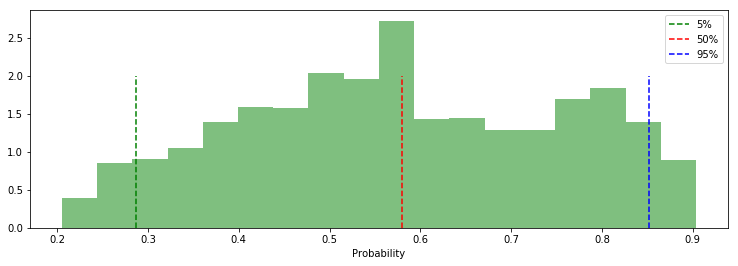

In [132]:
plt.figure(figsize=(12.5,4))
line_height = 2
data = averagingModels(np.concatenate(X_list, axis=0), best_models)
x = plt.hist(data, bins='auto', density=True, facecolor='green', alpha=0.5)

plt.vlines(np.percentile(data, 5), 0, line_height, linestyle="--", colors='green', label="5%")
plt.vlines(np.percentile(data, 50), 0, line_height, linestyle="--", colors='red', label="50%")
plt.vlines(np.percentile(data, 95), 0, line_height, linestyle="--", colors='blue', label="95%")
plt.xlabel('Probability')
plt.legend()

In [133]:
rows = []
for model in best_models:
    rows.append(model.get_params())
pd.DataFrame(rows)

,base_score,booster,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_delta_step,max_depth,min_child_weight,missing,n_estimators,n_jobs,nthread,objective,random_state,reg_alpha,reg_lambda,scale_pos_weight,seed,silent,subsample
0,0.575746,gbtree,0.698001,0.982019,0.345849,0.011552,0.003087,3,6,2,None,905,-1,None,binary:logistic,0,0.754164,0.774198,0.874570,None,True,0.639192
1,0.575746,gbtree,0.557606,0.897044,0.480846,0.000141,0.005471,1,5,4,None,385,-1,None,binary:logistic,0,1.517277,1.081674,1.010155,None,True,0.193468
2,0.575746,gbtree,0.196159,0.787042,0.671525,0.000243,0.007982,4,5,5,None,863,-1,None,binary:logistic,0,1.087579,0.000000,1.224314,None,True,0.103061
3,0.575746,gbtree,0.989102,0.481679,0.528293,0.100000,0.002662,0,5,5,None,950,-1,None,binary:logistic,0,0.617033,0.503922,1.283947,None,True,0.100000
4,0.575746,gbtree,0.604848,1.000000,0.471752,0.002799,0.005656,2,3,2,None,414,-1,None,binary:logistic,0,2.000000,0.933756,0.875399,None,True,0.722771
5,0.575746,gbtree,0.910587,0.162291,0.634338,0.031541,0.003096,1,5,2,None,746,-1,None,binary:logistic,0,0.177861,0.773540,0.875441,None,True,0.506452
6,0.575746,gbtree,0.100000,0.928913,1.000000,0.100000,0.015239,0,4,5,None,200,-1,None,binary:logistic,0,0.938493,2.000000,0.961662,None,True,0.417276
7,0.575746,gbtree,0.438199,0.470181,0.293761,0.000105,0.020237,1,4,2,None,403,-1,None,binary:logistic,0,1.887078,0.577422,1.168028,None,True,0.416464
8,0.575746,gbtree,0.265099,0.700939,0.600583,0.046421,0.003669,3,5,4,None,753,-1,None,binary:logistic,0,0.452719,1.460060,1.290142,None,True,0.191664
9,0.575746,gbtree,0.208172,0.755156,0.911456,0.000052,0.005098,3,3,3,None,997,-1,None,binary:logistic,0,0.888566,0.214298,0.943554,None,True,0.100000


## Train on the entire data set

In [134]:
from sklearn.metrics import make_scorer
import numpy as np
from xgboost.sklearn import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from time import time

n_calls = 50
cutoff_score = 80

def afl_loss(y_true, y_pred):
    return -np.sum(1 + np.log2(y_true * y_pred + (1 - y_true) * (1 - y_pred)))
scorer = make_scorer(afl_loss, greater_is_better=False, needs_proba=True)

space = {
    'n_estimators': Integer(200, 1000),
    'max_depth': Integer(3, 6),
    'learning_rate': Real(10 ** -4, 0.1, "log-uniform"),
    'gamma': Real(10 ** -5, 0.1, "log-uniform"),
    'min_child_weight': Integer(1, 5),
    'scale_pos_weight': Real(0, 2, "uniform"),
    'max_delta_step': Integer(0, 5),
    'colsample_bytree': Real(0.1, 1.0, "uniform"),
    'colsample_bylevel': Real(0.1, 1.0, "uniform"),
    'colsample_bynode': Real(0.1, 1.0, "uniform"),
    'subsample': Real(0.1, 1.0, "uniform"),
    'reg_lambda': Real(0.0, 2.0, "uniform"),
    'reg_alpha': Real(0.0, 2.0, "uniform"),
        }

classifier = XGBClassifier(base_score=0.57574568288854, n_jobs=-1)

start = time()
opt = BayesSearchCV(classifier, search_spaces=space, scoring=scorer, cv=5, n_iter=n_calls, n_jobs=-1)

# callback handler
def on_step(iteration):
    score = opt.best_score_
    if score > cutoff_score:
        print('Interrupting!')
        return True

opt.fit(Features().div_cols(X), y, callback=on_step)
model = opt.best_estimator_
print('Entire data set')
print("Bayes CV search took %.2f seconds for %d candidates"
        " parameter settings." % ((time() - start), n_calls))
print("val. score:", opt.best_score_)
print(model)

Entire data set
Bayes CV search took 175.51 seconds for 50 candidates parameter settings.
val. score: 69.9318683472209
XGBClassifier(base_score=0.57574568288854, booster='gbtree',
       colsample_bylevel=0.7902171735316731, colsample_bynode=0.1,
       colsample_bytree=0.8640276971742528, gamma=7.686380366726353e-05,
       learning_rate=0.0064770350433801934, max_delta_step=1, max_depth=3,
       min_child_weight=2, missing=None, n_estimators=691, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1.2507819515989722, reg_lambda=1.1543259131376238,
       scale_pos_weight=1.1881929923037489, seed=None, silent=True,
       subsample=0.5925638753350252)


In [135]:
pd.DataFrame(data=model.feature_importances_,
             index=Features().cols() + ['perc','R_mean'], 
             columns=['importance']).sort_values(by=['importance'], ascending=False)

,importance
perc,0.116894
R_mean,0.087577
a_M_mean,0.083945
h_M_mean,0.077551
h_perc,0.077251
a_perc,0.071370
h_R_mean,0.071141
h_A_mean,0.059761
a_A_mean,0.059169
a_R_mean,0.053932


## Scoring

In [17]:
from data_prep.web_scraping import Scrape

games = []
start = 122
for i in range(start,start+9):
    games.append(Scrape(mapping, proxyDict).scrape_game(i))
games

/Users/d719674/dev/code/AFL-Monash-comp/data_prep/web_scraping.py:35: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 35 of the file /Users/d719674/dev/code/AFL-Monash-comp/data_prep/web_scraping.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(r.text, "html")


[['North Melbourne', 'Richmond'],
 ['Collingwood', 'Fremantle'],
 ['Greater Western Sydney', 'Gold Coast'],
 ['Geelong', 'Sydney'],
 ['Brisbane Lions', 'Hawthorn'],
 ['Melbourne', 'Adelaide'],
 ['St Kilda', 'Port Adelaide'],
 ['Essendon', 'Carlton'],
 ['West Coast', 'Western Bulldogs']]

In [109]:
from modelling.scoring import Scoring
scoring = Scoring(mapping, proxyDict).score_data(games)

In [110]:
pd.DataFrame(scoring, columns=cols)[imp.iloc[:10,:].index]

,perc,R_mean,h_M_mean,h_perc,a_M_mean,a_perc,h_R_mean,a_A_mean,h_A_mean,a_R_mean
0,0.814403,0.428571,-12.6,0.864662,4.9,1.061713,0.3,79.4,93.1,0.7
1,1.165457,1.600000,20.1,1.275342,6.6,1.094286,0.8,70.0,73.0,0.5
2,1.725246,2.333333,22.0,1.299728,-20.2,0.753358,0.7,81.9,73.4,0.3
3,1.705993,3.000000,31.5,1.457849,-12.8,0.854545,0.9,88.0,68.8,0.3
4,0.993519,1.200000,2.7,1.031034,2.9,1.037760,0.6,76.8,87.0,0.5
5,0.678294,0.600000,-22.1,0.758206,8.4,1.117812,0.3,71.3,91.4,0.5
6,0.890272,1.000000,-6.7,0.917284,2.4,1.030341,0.5,79.1,81.0,0.5
7,1.275316,4.000000,-1.7,0.978344,-21.4,0.767138,0.4,91.9,78.5,0.1
8,1.080655,1.750000,1.2,1.015915,-5.2,0.940092,0.7,86.8,75.4,0.4


In [136]:
def modelStats(X, models=[]):
    predictions = np.column_stack([
        model.predict_proba(X)[:,1] for model in models
    ])
    return [np.mean(predictions, axis=1), np.median(predictions, axis=1), np.std(predictions, axis=1), 
            np.max(predictions, axis=1), np.min(predictions, axis=1)]

arr = np.c_[ games, model.predict_proba(scoring)[:,1], modelStats(scoring,best_models)[0],
           modelStats(scoring,best_models)[1],modelStats(scoring,best_models)[2],
            modelStats(scoring,best_models)[3], modelStats(scoring,best_models)[4]] 
pd.DataFrame(arr,columns=['home','away', 'prob','prob_avg', 'prob_med', 'prob_std', 'prob_max', 'prob_min'])

,home,away,prob,prob_avg,prob_med,prob_std,prob_max,prob_min
0,North Melbourne,Richmond,0.43922597,0.40952066,0.41385666,0.02868074,0.45854738,0.34560007
1,Collingwood,Fremantle,0.69559014,0.64408505,0.6389822,0.03611614,0.71423143,0.5848914
2,Greater Western Sydney,Gold Coast,0.8501513,0.811555,0.8081752,0.025843062,0.8677506,0.7642701
3,Geelong,Sydney,0.8432168,0.7917427,0.7901505,0.025288302,0.8414803,0.75631076
4,Brisbane Lions,Hawthorn,0.62953055,0.59561545,0.6027808,0.037788283,0.6543293,0.5368281
5,Melbourne,Adelaide,0.34469694,0.31298867,0.30928737,0.03508999,0.37933588,0.2640621
6,St Kilda,Port Adelaide,0.5320639,0.50111127,0.5001244,0.037203033,0.56825155,0.43587193
7,Essendon,Carlton,0.83762264,0.80345315,0.8015674,0.021113101,0.8495425,0.7661592
8,West Coast,Western Bulldogs,0.69810027,0.6683496,0.6666478,0.03077444,0.7216599,0.60041726


## Save models

In [137]:
from joblib import dump
dump(model, 'models/model.joblib') 
for i in range(len(best_models)):
    dump(best_models[i], 'models/model'+str(i)+'.joblib') 

## Load models

In [138]:
from joblib import load
model = load('models/model.joblib')
best_models = []
for i in range(15):
    best_models.append(load('models/model'+str(i)+'.joblib'))

## Model Analysis

In [139]:
overall = []
def afl_loss(y_true, y_pred):
    return np.sum(1 + np.log2(y_true * y_pred + (1 - y_true) * (1 - y_pred)))
for i in range(len(best_models)):
    season_scores = []
    for rnd in range(1,24):
        df = pd.DataFrame(np.c_[X_list[i],y_list[i]])
        y_new = df[df[0] == rnd][17].values
        x_new = df[df[0] == rnd].drop(17, axis=1).values
        score = afl_loss(y_new,best_models[i].predict_proba(Features().div_cols(x_new))[:,1])
        season_scores.append(score)
    overall.append(season_scores)

Text(0.5, 1.0, 'Average Cumulative Score')

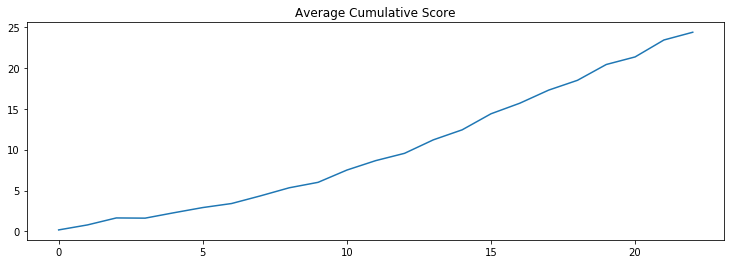

In [148]:
plt.figure(figsize=(12.5,4))
plt.plot(np.cumsum(np.array(np.matrix(np.array(overall)).mean(0)).flatten()))
plt.title('Average Cumulative Score')

In [141]:
from modelling.scoring import Simulate
Simulate(mapping,proxyDict).generate_past_scores('training-all', best_models, team_df)

['Richmond', 'West Coast', 'Sydney', 'Adelaide', 'Geelong', 'Greater Western Sydney', 'Melbourne', 'Port Adelaide', 'Collingwood', 'Hawthorn', 'Essendon', 'Western Bulldogs', 'St Kilda', 'North Melbourne', 'Kangaroos', 'Fremantle', 'Brisbane Lions', 'Gold Coast', 'Carlton']


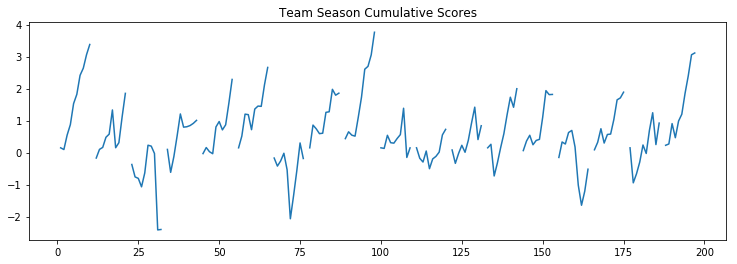

In [150]:
year = 2018
plt.figure(figsize=(12.5,4))
plt.plot(np.load('training-all/scores-'+str(year)+'.npy')[:,0])
plt.title('Team Season Cumulative Scores')
print(teams)

['Richmond', 'West Coast', 'Sydney', 'Adelaide', 'Geelong', 'Greater Western Sydney', 'Melbourne', 'Port Adelaide', 'Collingwood', 'Hawthorn', 'Essendon', 'Western Bulldogs', 'St Kilda', 'North Melbourne', 'Kangaroos', 'Fremantle', 'Brisbane Lions', 'Gold Coast', 'Carlton']


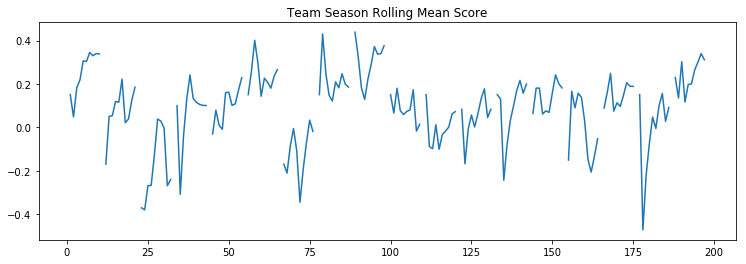

In [151]:
plt.figure(figsize=(12.5,4))
plt.plot(np.load('training-all/scores-'+str(year)+'.npy')[:,2])
plt.title('Team Season Rolling Mean Score')
print(teams)